In [1]:
noise_type = 7
noise_percent = 0.20

In [2]:
import os
import re
import random
import numpy as np
from tqdm import tqdm
from scipy.io import loadmat
import matplotlib.pyplot as plt
from pandas import DataFrame, concat

import torch
from torchinfo import summary
from torch.utils.data import DataLoader

from models.vae import VAE
from models.rnn_trainer import RNNTrainer

In [3]:
DATASET_PATH = os.path.join(os.getcwd(), 'data')
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = os.path.join(os.getcwd(), 'checkpoints')

In [4]:
seed = 13
torch.manual_seed(seed)
# torch.cuda.manual_seed(seed)
# torch.cuda.manual_seed_all(seed)
# torch.backends.cudnn.deterministic = True
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
class RNNDataset():
    def __init__(self, x, y):
        self.x = x
        self.y = y
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [6]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [7]:
latent_dim = 118
hidden_size = 100
num_layers = 2
batch_size = 16
rnn_window = 10
epochs = 1000
lr = 1e-1
scheduler = True
es_patience = 10

In [8]:
data_filename = 'Normal1.mat'
data = loadmat(os.path.join(DATASET_PATH, data_filename))
Z = data['Z']
T = len(Z)

In [9]:
vae = VAE(latent_dim).to(device)
vae.load_state_dict(torch.load(os.path.join(CHECKPOINT_PATH, f'vae_{int(noise_percent*100)}%.pt')))

<All keys matched successfully>

In [10]:
# read attack noise
NOISE_PATH = os.path.join(DATASET_PATH, f'I{noise_type}')
Z_noise = dict()
for filename in tqdm(os.listdir(NOISE_PATH), desc='Reading noise data ... '):
    fname = os.path.join(NOISE_PATH, filename)
    data = loadmat(fname)
    att_type = int(re.findall(r'\d+', filename)[0])
    Z_noise[att_type] = np.array(data['Z'])

Z_noise = dict(sorted(Z_noise.items()))

Reading noise data ... : 100%|██████████| 3/3 [00:00<00:00,  6.42it/s]


In [11]:
noise_size = int(T * noise_percent)
norm_operation_win = 50
# sample random times after norm_operation_win to add in Z
noise_time = np.random.choice(list(range(norm_operation_win, T)), size=noise_size, replace=False)
# sample attack types to sample a noise
noise_to_add_from = np.random.choice(list(Z_noise.keys()), size=noise_size, replace=True).tolist()
random.shuffle(noise_to_add_from)
# randomly select noises from attack types
noises = []
for typ in noise_to_add_from:
    noise_id = random.sample(range(T), 1)
    noises.append(Z_noise[typ][noise_id])
random.shuffle(noises)
noises = np.concatenate(noises, axis=0)
# add noises to original sensor data Z
Z[noise_time,:] = noises
Z = torch.tensor(Z, dtype=torch.float32).to(device)


In [12]:
vae.eval()
Z_enc = vae.encoder(Z)
Z_supervised = series_to_supervised(Z_enc.cpu().detach().numpy(), n_in=rnn_window)
Z_supervised = Z_supervised.values
X, y = Z_supervised[:,:rnn_window * latent_dim], Z_supervised[:, rnn_window * latent_dim:]
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]
training = RNNDataset(X_train, y_train)
test = RNNDataset(X_test, y_test)
train_dl = DataLoader(training, batch_size=batch_size, shuffle=True)
test_dl = DataLoader(test)

In [13]:
trainer = RNNTrainer(input_dim=rnn_window * latent_dim, 
                     outputdims = latent_dim,
                     hidden_dim=hidden_size,
                     num_layers=num_layers,
                     lr=lr,
                     lr_scheduler=scheduler,
                     es_patience=es_patience,
                     checkpoint_name=f'rnn_{int(noise_percent*100)}%.pt',
                     seed=13)

Device:  cuda


In [14]:
summary(trainer.rnn, (1, rnn_window * latent_dim))

Layer (type:depth-idx)                   Output Shape              Param #
RNN                                      [1, 118]                  --
├─LSTM: 1-1                              [1, 50]                   543,600
├─Linear: 1-2                            [1, 118]                  6,018
Total params: 549,618
Trainable params: 549,618
Non-trainable params: 0
Total mult-adds (M): 27.19
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 2.20
Estimated Total Size (MB): 2.20

In [15]:
rnn, mse, val_mse = trainer.train(train_dl=train_dl,
                                  test_dl=test_dl,
                                  epochs=epochs)

Epoch 1/1000: [MSE: 56.6015], [Val_MSE: 4.7427], 
Validation loss decreased (inf --> 4.742750).  Saving model ...
Epoch 2/1000: [MSE: 114.2669], [Val_MSE: 908.3126], 
EarlyStopping counter: 1 out of 10
Epoch 3/1000: [MSE: 115.3821], [Val_MSE: 63.5624], 
EarlyStopping counter: 2 out of 10
Epoch 4/1000: [MSE: 278.4035], [Val_MSE: 10.1443], 
EarlyStopping counter: 3 out of 10
Epoch 5/1000: [MSE: 1652.6169], [Val_MSE: 198.7638], 
EarlyStopping counter: 4 out of 10
Epoch 6/1000: [MSE: 40.2895], [Val_MSE: 5.8304], 
EarlyStopping counter: 5 out of 10
Epoch 7/1000: [MSE: 2.9949], [Val_MSE: 2.7634], 
Validation loss decreased (4.742750 --> 2.763423).  Saving model ...
Epoch 8/1000: [MSE: 1.9024], [Val_MSE: 1.4738], 
Validation loss decreased (2.763423 --> 1.473796).  Saving model ...
Epoch 9/1000: [MSE: 1.3017], [Val_MSE: 1.3032], 
Validation loss decreased (1.473796 --> 1.303213).  Saving model ...
Epoch 10/1000: [MSE: 2.0561], [Val_MSE: 1.7130], 
EarlyStopping counter: 1 out of 10
Epoch 11/10

In [16]:
def plot_learning(mse, val_mse):
    fig, axs = plt.subplots(figsize=(8,4))
    axs.plot(mse, color='r', label='Training')
    axs.plot(val_mse, color='b', label='Validation')
    axs.set_title('MSE vs. Validation MSE')
    plt.legend()
    # plt.savefig('./img/mrnntraining.pdf', format='pdf', dpi=1200)
    plt.show()

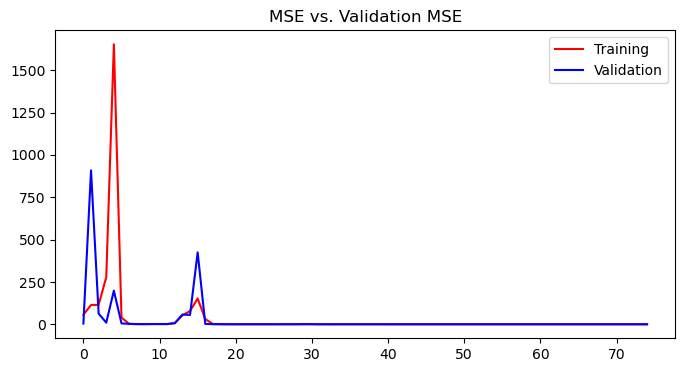

In [17]:
plot_learning(mse, val_mse)

In [18]:
zz0 = torch.tensor(X_test[-3:-1,:], dtype=torch.float32).to(device)
rnn.eval()
zz = rnn(zz0)
s_rec = vae.decoder(zz)

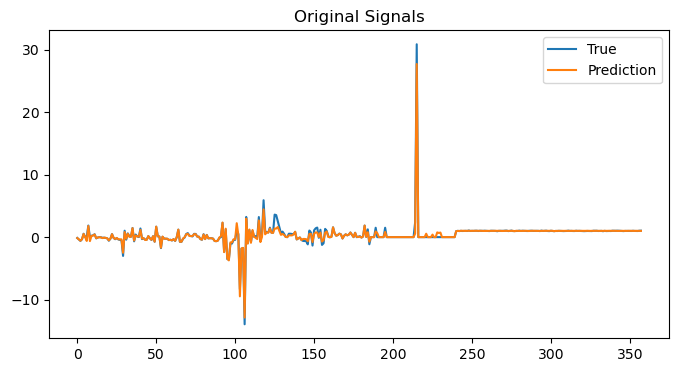

In [19]:
fig, axs = plt.subplots(figsize=(8,4))
axs.plot(np.transpose(Z.cpu().detach().numpy()[-1,:]), label='True')
axs.plot(np.transpose(s_rec[1,:].cpu().detach().numpy()), label='Prediction')
axs.set_title('Original Signals')
plt.legend()
plt.show()

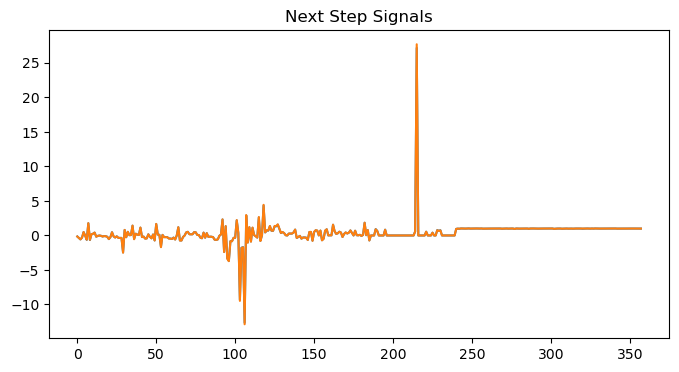

In [20]:
fig, axs = plt.subplots(figsize=(8,4))
axs.plot(np.transpose(s_rec.cpu().detach().numpy()))
axs.set_title('Next Step Signals')
plt.show()